In [1]:
%run './data_processing.ipynb'

Remaining rows:  6848


In [61]:
% config InlineBackend.figure_format = 'retina'
% matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8

In [157]:
import sklearn
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn import preprocessing, linear_model
from sklearn.metrics import mean_squared_error
import patsy
from sklearn.model_selection import train_test_split

In [3]:
CONTINUOUS_FEATURES = ['HH_SIZE', 'HH_CHILD',
                        'AGE',
                      'PED', 'SED_EAT', 'EXFREQ', 'FASTFDFREQ']
# cannot include weight and height because these are directly associated with
# BMI
EXCLUDED_CONTINUOUS_FEATURES = ['HEIGHT', 'WEIGHT']
CATEGORICAL_FEATURES = ['FAMINCOME', 'POVERTY130', 'POVERTY185',
                       'POVERTYLEVEL', 'FOODSTAMP', 'WIC',
                       'HHTENURE', 'HOUSETYPE', 'QFAMINCOME',
                       'GENHEALTH', 'SEX', 'RACE', 'MARST',
                       'EH_RESP', 'FOODSHOP', 'MEALPREP',
                       'SODA', 'DIETSODA', 'MILK', 'MEAT', 'STORE', 'STREASON', 'EXERCISE',
                       'FASTFD', 'FDTHERM', 'ENOUGHFD', 'ANYSECDRK',
                       'ANYSECEAT']

In [40]:
# Generate feature matrix and label array
# X = df_atus[CATEGORICAL_FEATURES + CONTINUOUS_FEATURES].as_matrix()
# y = df_atus['BMI'].as_matrix()

In [121]:
# Write a patsy specification that one-hot encodes all categorical variables
patsy_spec = ' + '.join(CONTINUOUS_FEATURES)
patsy_spec += ' + '
patsy_spec += ' + '.join(['C({0})'.format(c) for c in CATEGORICAL_FEATURES])
patsy_spec += ' - 1' # remove intercept
patsy_spec

'HH_SIZE + HH_CHILD + AGE + PED + SED_EAT + EXFREQ + FASTFDFREQ + C(FAMINCOME) + C(POVERTY130) + C(POVERTY185) + C(POVERTYLEVEL) + C(FOODSTAMP) + C(WIC) + C(HHTENURE) + C(HOUSETYPE) + C(QFAMINCOME) + C(GENHEALTH) + C(SEX) + C(RACE) + C(MARST) + C(EH_RESP) + C(FOODSHOP) + C(MEALPREP) + C(SODA) + C(DIETSODA) + C(MILK) + C(MEAT) + C(STORE) + C(STREASON) + C(EXERCISE) + C(FASTFD) + C(FDTHERM) + C(ENOUGHFD) + C(ANYSECDRK) + C(ANYSECEAT) - 1'

In [122]:
# create a patsy design matrix for all features incl one-hot-encoded features. 
# Used to lookup feature index -> feature name later
d = patsy.dmatrix(patsy_spec, df_atus)

In [145]:
# Generate features and labels based on patsy specification
y, X = patsy.dmatrices('BMI ~ ' + patsy_spec, df_atus)

In [152]:
# Generate yes/no obesity labels (BMI >= 30 is obese)
y_train_clf = [1 if y >= 30 else 0 for y in y]

In [153]:
assert len(y) == len(X)

In [166]:
# Split data into training, validation, and test set

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.4)
X_validation, X_test, y_validation, y_test = train_test_split(X_validation, y_validation, test_size=0.3)

In [155]:
X_train_clf, X_train_test_clf, y_train_clf, y_train_test = train_test_split(X, y_train_clf, test_size=0.4)

## Fit Random Forest classifier

In [163]:
clf_model = RandomForestClassifier()
clf_model.fit(X_train_clf, y_train_clf)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [164]:
clf_model.score(X_train_test_clf, y_train_test)

0.70036496350364963

## Fit Random Forest decision-tree model on the data using mean squared error as criterion

In [171]:
model = RandomForestRegressor()
model.fit(X_train, np.ravel(y_train))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

### Evaluate model fit on validation set

In [172]:
# R^2
model.score(X_validation, y_validation)

0.067622580794251874

In [173]:
# RMSE of random forest model
np.sqrt(mean_squared_error(y_validation, model.predict(X_validation)))

6.1140901219044483

### Investigate feature importances

In [131]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
#feature_names = df_atus[CATEGORICAL_FEATURES + CONTINUOUS_FEATURES].columns
feature_names = d.design_info.column_names

# Print the feature ranking
print("Feature ranking (best to worst):")

for f in range(X.shape[1]):
    print("%d. feature %d (%s): %f" % (f + 1, indices[f], feature_names[f], importances[indices[f]]))

Feature ranking (best to worst):
1. feature 125 (C(FAMINCOME)[1]): 0.127535
2. feature 126 (C(FAMINCOME)[2]): 0.081311
3. feature 127 (C(FAMINCOME)[3]): 0.045977
4. feature 46 (C(FAMINCOME)[4]): 0.040103
5. feature 129 (C(FAMINCOME)[5]): 0.038501
6. feature 128 (C(FAMINCOME)[6]): 0.036609
7. feature 45 (C(FAMINCOME)[7]): 0.036292
8. feature 123 (C(FAMINCOME)[8]): 0.033043
9. feature 47 (C(FAMINCOME)[9]): 0.020814
10. feature 50 (C(FAMINCOME)[10]): 0.019636
11. feature 51 (C(FAMINCOME)[11]): 0.015001
12. feature 25 (C(FAMINCOME)[12]): 0.014443
13. feature 70 (C(FAMINCOME)[13]): 0.014321
14. feature 10 (C(FAMINCOME)[14]): 0.012590
15. feature 33 (C(FAMINCOME)[15]): 0.011868
16. feature 11 (C(FAMINCOME)[16]): 0.011404
17. feature 8 (C(POVERTY130)[T.12.0]): 0.011287
18. feature 53 (C(POVERTY130)[T.20.0]): 0.010704
19. feature 78 (C(POVERTY130)[T.96.0]): 0.010692
20. feature 98 (C(POVERTY130)[T.97.0]): 0.010664
21. feature 5 (C(POVERTY130)[T.99.0]): 0.010509
22. feature 27 (C(POVERTY185)[T.

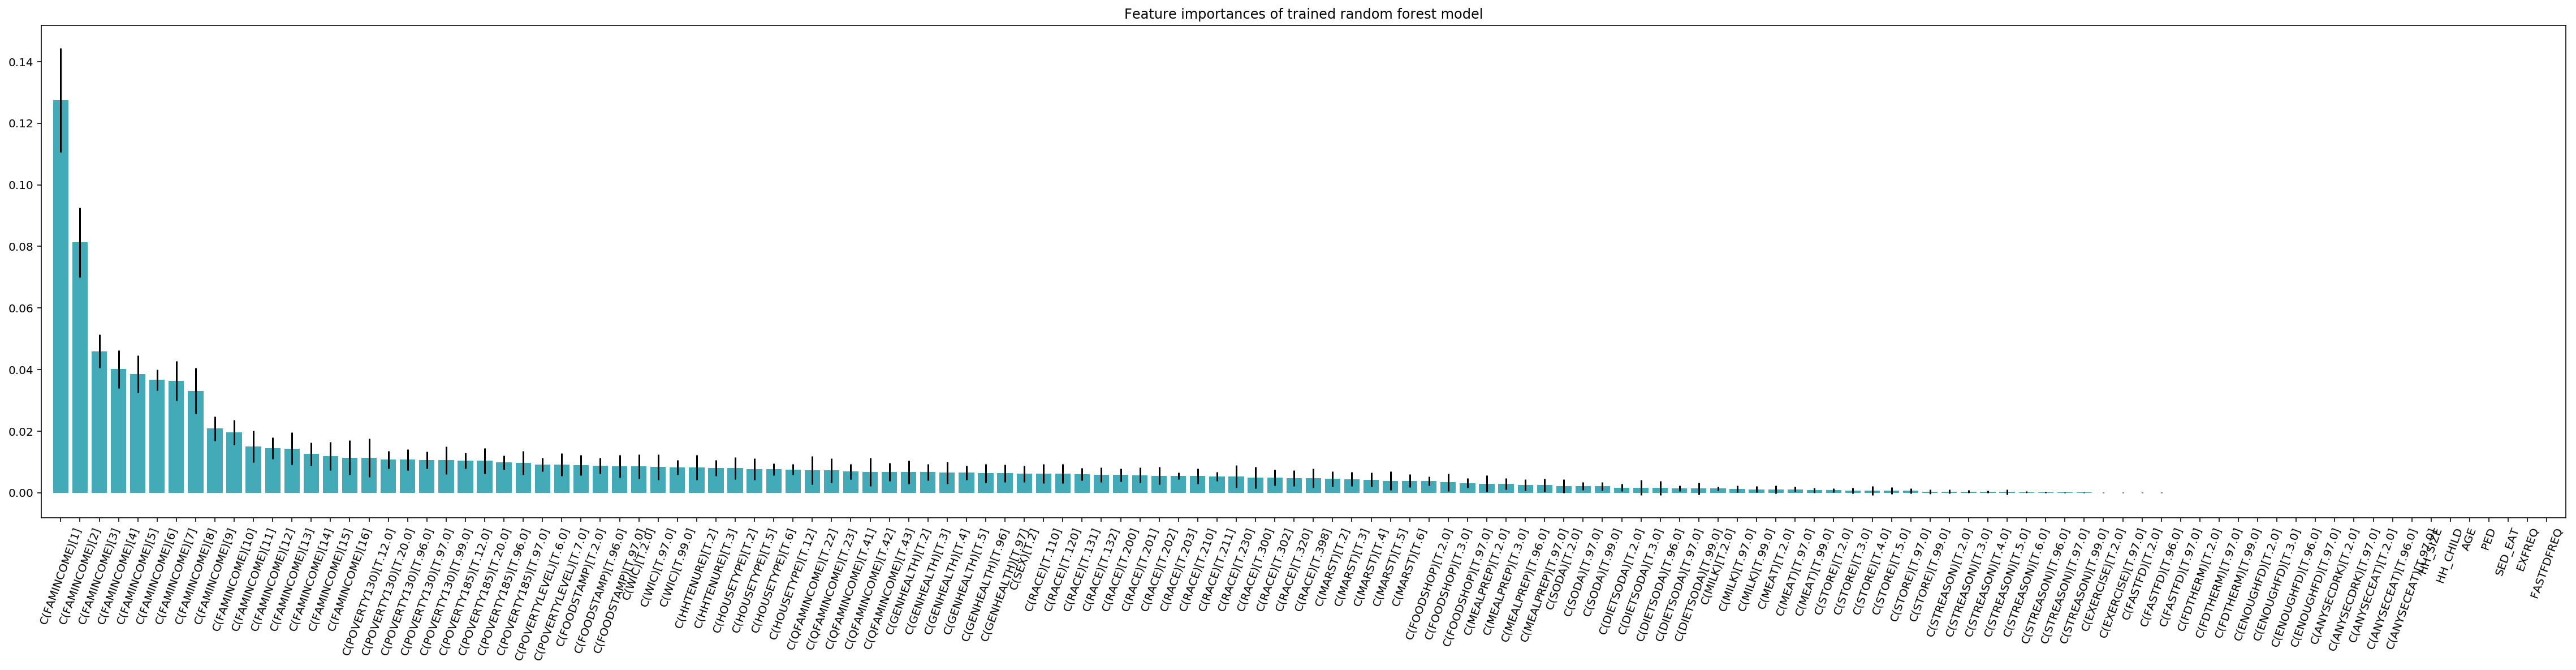

In [133]:
# Plot the feature importances of the forest
std = np.std([tree.feature_importances_ for tree in model.estimators_],axis=0)

fig = plt.gcf()
fig.set_size_inches(40, 8)

plt.title("Feature importances of trained random forest model")
plt.bar(range(X.shape[1]), importances[indices],
       color='#43ABB7', yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names, rotation=70)
plt.xlim([-1, X.shape[1]])
plt.show()

## Multivariate linear regression model

In [138]:
lin_model = linear_model.LinearRegression(normalize=True, fit_intercept=True)
lin_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [139]:
lin_model.score(X_validation, y_validation)

-1.9076586493645899e+25

In [140]:
# RMSE of linear model
np.sqrt(mean_squared_error(y_validation, lin_model.predict(X_validation)))

28020181334642.863

Clearly horrible results, due to presumably non-linear relationships